# Simple PINN for an elastic plate with a hole 

## Represent geometry

We represent the geometry by a set of collocation points 

radius x-axis:  0.7
radius y-axis:  0.35714285714285715


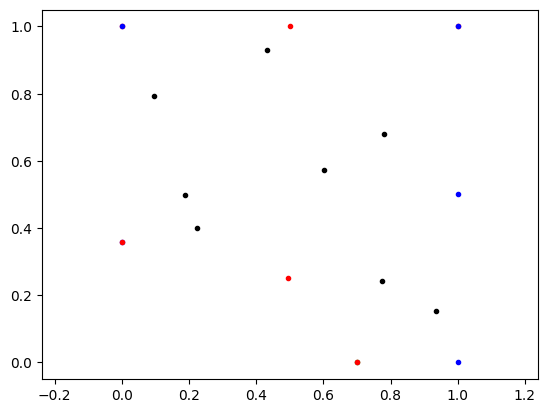

In [210]:
import torch
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt
import random
from math import pi, ceil
from plate_elliptic_hole import Plate 

# Applied strain at right boundary
EPS0 = 0.1
# Applied body force field
B0 = 0.0
# Lame constants
MU = 1
LBD = 2

Ra_x = 0.7 #radius on the x-axis of the ellipse 
SuAr= 0.25*pi   #surface area of the eclipse (= equal to SuAr of a circle with R=0.5)
Min_Ra_x = 0.25 #minimal radius on the x-axis of the ellipse
Max_Ra_x = 0.8 #maximum radius on the x-axis of the ellipse
L = 1 #length of plate #info: muss noch gefixt werden -> momentan bei 1 lassen
N = 3 #number of collocation Point in x-axis direction
P = 3 #number of plates in dataset
NN = ceil(N * (L-Ra_x)/L) #number of collocation Point in both direction


def generate_tensor_for_radius(x,r):
    #print("Shape of r before sizing ", r.size())
    r = torch.tensor([r]*x.size(dim=0))
    #print("Shape of r after sizing ", r.size())
    return r

def slice_tensor_for_radius(x_tensor,tensor_r):
    length = x_tensor.size(dim=0)
    new_tensor_r = tensor_r[:length]
    return new_tensor_r

def generate_multiple_plates_dict(iteration):
    dict_plate_points = dict()
    tuples = [
            ("x_collo", 0, 0),
            ("y_collo", 0, 1),
            ("x_top", 1, 0),
            ("y_top", 1, 1),
            ("x_right", 1, 2),
            ("y_right", 1, 3),
            ("x_left", 1, 4),
            ("y_left", 1, 5),
            ("x_bottom", 1, 6),
            ("y_bottom", 1, 7),
            ("x_hole", 1, 8),
            ("y_hole", 1, 9),
            ("n_hole", 1, 10)
            #("radius_x", 2, 0)
        ] 
    for i in range(iteration):
        p1 = Plate(Ra_x, SuAr, L, N)
        data_one_plate = p1.generate_dataset(Re_xnew, Re_ynew, L, N)
        for tuple in tuples:
            key = tuple[0]
            dict_plate_points.setdefault(key, []).append(data_one_plate[tuple[1]][tuple[2]])
        #print(dict_plate_points["radius_x"])
        #p1.plot_plate_with_hole(*data_one_plate)
    for key in dict_plate_points: 
        #print(key, "  ",dict_plate_points[key])
        #appending list of tensors to one tensor
        dict_plate_points[key] = torch.cat(dict_plate_points[key])
        if(key is not str("n_hole")):
            dict_plate_points[key] = torch.flatten(dict_plate_points[key])
        #print(key, "  ",dict_plate_points[key])
        #print(key, "shape is", dict_plate_points[key].size())
    #print(dict_plate_points)
    #print(dict_plate_points["n_hole"])
    return dict_plate_points


p2 = Plate(Ra_x, SuAr, L, N)
Re_xnew, Re_ynew = p2.create_ellipse(Ra_x,SuAr, L)
#p2.plot_quarter_elli(Re_xnew, Re_ynew)
data_train_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
data_test_points = p2.generate_dataset_test(Re_xnew, Re_ynew, L, N)
train_plates_data = generate_multiple_plates_dict(P)
test_plates_data = generate_multiple_plates_dict(1)

#ToDo: rad_x has to be initizialed in a function, every time the radius changes
#rad_x = torch.tensor([Re_xnew]*train_plates_data["x_collo"].size(dim=0))
rad_x = torch.tensor([Re_xnew])
p2.plot_plate_with_hole(*data_train_points)
#p2.plot_plate_with_hole(*data_test_points)


In [211]:
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        hn = 20
        self.hidden_layer1 = torch.nn.Linear(3,hn)
        self.hidden_layer2 = torch.nn.Linear(hn,hn)
        self.hidden_layer3 = torch.nn.Linear(hn,hn)
        self.hidden_layer4 = torch.nn.Linear(hn,hn)
        self.hidden_layer5 = torch.nn.Linear(hn,hn)
        self.output_layer = torch.nn.Linear(hn,2)

    def forward(self, x, y, r):
        rad_x = generate_tensor_for_radius(x,r)

        inputs = torch.column_stack([x, y, rad_x])
        layer1_out = torch.tanh(self.hidden_layer1(inputs))
        layer2_out = torch.tanh(self.hidden_layer2(layer1_out))
        layer3_out = torch.tanh(self.hidden_layer3(layer2_out))
        layer4_out = torch.tanh(self.hidden_layer4(layer3_out))
        layer5_out = torch.tanh(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

## The physics

We want to solve linear elasticity on the domain, which means ultimately that we want to minimize the residual of the PDE 
$$
    \nabla \cdot \sigma - \mathbf{b} = \mathbf{0}. 
$$

In [212]:
def sigma(eps):
    I = torch.eye(2)
    return 2.0 * MU * eps + LBD * torch.einsum("...ii,...jk->...jk", eps, I)

def epsilon(x, y, r, net):
    disp = net(x, y, r)
    u = disp[:,0]
    v = disp[:,1]
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    v_x = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    v_y = torch.autograd.grad(v.sum(), y, create_graph=True)[0]

    gradx = torch.column_stack([u_x, v_x])
    grady = torch.column_stack([u_y, v_y])
    gradient = torch.stack([gradx, grady], dim=2)

    return 0.5 * (gradient + torch.transpose(gradient, 1, 2))

def pde_residual(x, y, r, net):
    stress = sigma(epsilon(x,y,r, net))
    sxx = stress[:,0,0]
    sxy = stress[:,0,1]
    syx = stress[:,1,0]
    syy = stress[:,1,1]
    

    sxx_x = torch.autograd.grad(sxx.sum(), x, create_graph=True)[0]
    sxy_y = torch.autograd.grad(sxy.sum(), y, create_graph=True)[0]
    syx_x = torch.autograd.grad(syx.sum(), x, create_graph=True)[0]
    syy_y = torch.autograd.grad(syy.sum(), y, create_graph=True)[0]

    residual_x = sxx_x + sxy_y - B0
    residual_y = syx_x + syy_y
    return residual_x, residual_y


## The loss function

In [213]:
W_PDE = 0.01
W_NEUMANN = 0.01

mse = torch.nn.MSELoss()


def compute_loss(net,x_collo, y_collo, x_top, y_top, x_right, y_right, x_left, y_left, x_bottom, y_bottom, x_hole, y_hole, n_hole, rad_x):
    # pde
    rad_x1 = slice_tensor_for_radius(x_collo,rad_x)
    res_x, res_y = pde_residual(x_collo, y_collo, rad_x1, net)
    zeros = torch.zeros_like(res_x)
    pde_error = mse(res_x, zeros) + mse(res_y, zeros)

    # left boundary
    rad_x2 = slice_tensor_for_radius(x_collo,rad_x)
    pred_left = net(x_left, y_left, rad_x2)
    bc_left = torch.zeros_like(pred_left[:,0])
    left_error = mse(pred_left[:,0], bc_left) 

    # right boundary
    rad_x3 = slice_tensor_for_radius(x_collo,rad_x)
    pred_right = net(x_right, y_right, rad_x3)
    bc_right = EPS0 * L * torch.ones_like(pred_right[:,0])
    right_error = mse(pred_right[:,0], bc_right) 

    # bottom boundary
    rad_x4 = slice_tensor_for_radius(x_collo,rad_x)
    pred_bottom = net(x_bottom, y_bottom, rad_x4)
    bc_bottom = torch.zeros_like(pred_bottom[:,1])
    bottom_error = mse(pred_bottom[:,1], bc_bottom) 

    # top boundary
    rad_x5 = slice_tensor_for_radius(x_collo,rad_x)
    stress_top = sigma(epsilon(x_top, y_top, rad_x5, net))
    zeros = torch.zeros_like(stress_top[:,1,1])
    top_error = mse(stress_top[:,1,1], zeros) + mse(stress_top[:,0,1], zeros)

    # hole boundary
    rad_x6 = slice_tensor_for_radius(x_collo,rad_x)
    stress_hole = sigma(epsilon(x_hole, y_hole, rad_x6, net))
    traction = torch.einsum("...ij,...j->...i", stress_hole, n_hole)
    zeros = torch.zeros_like(traction[:,0])
    hole_error = mse(traction[:,0], zeros) + mse(traction[:,1], zeros)

    return (
        left_error
        + right_error
        + bottom_error
        + W_NEUMANN * top_error
        + W_NEUMANN * hole_error
        + W_PDE * pde_error
    )


## Training 

In [214]:
net = Net()
train_data = []
test_data = []
rad_x = rad_x
epochs = 15000
iterations = 3
epochs_per_iter = int(epochs/iterations)
LeRa = 0.1


for iteration in range(iterations):
    LeRa = LeRa/(10**1)
    print("Switching to Adam optimizer with lr =",LeRa,"for",epochs_per_iter,"epoch...")
    optimizer = torch.optim.Adam(net.parameters(), LeRa)
    for epoch in range(epochs_per_iter):
        optimizer.zero_grad()
        #old code
        loss_train = compute_loss(net, *train_plates_data.values(), rad_x)
        loss_test = compute_loss(net, *test_plates_data.values(), rad_x)
        #new code
        #loss_train = compute_loss(net, *train_plates_data.values())
        #loss_test = compute_loss(net, *test_plates_data.values())
        loss_train.backward(retain_graph=True)
        optimizer.step()
        with torch.autograd.no_grad():
            train_data.append(float(loss_train.data))
            test_data.append(float(loss_test.data))



        
plt.plot(train_data, c='g', label='train', linewidth=5.0)
plt.plot(test_data, c='r', label='test')
plt.yscale("log")
plt.title("Training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()




Switching to Adam optimizer with lr = 0.01 for 5000 epoch...
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([20])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([6])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([9])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([3])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([9])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([9])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([7])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([2])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([3])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([1])
Shape of r before sizing  torch.Size([1])
Shape of r after sizing  torch.Size([3])
Shape of r before sizing 

KeyboardInterrupt: 

## Visualization of results

Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2001])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2001])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2001])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2004])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2004])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2004])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2002])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2002])
Shape of r before sizing  torch.Size([])
Shape of r after sizing  torch.Size([2002])


'\nplt.subplot(5, 3, 1)\ncreate_subplot(stress[:, 0, 0], "Stress xx", data_test_points[1])\nplt.subplot(5, 3, 4)\ncreate_subplot(stress[:, 0, 1], "Stress xy", data_test_points[1])\nplt.subplot(5, 3, 7)\ncreate_subplot(stress[:, 1, 1], "Stress yy", data_test_points[1])\ncreate_subplot(disp[:, 0], "Displacement in x",data_test_points[1], cmap="inferno",)\ncreate_subplot(disp[:, 1], "Displacement in y", data_test_points[1], cmap="inferno_r")\n\nplt.suptitle("Validation with different radii")\nplt.show\n'

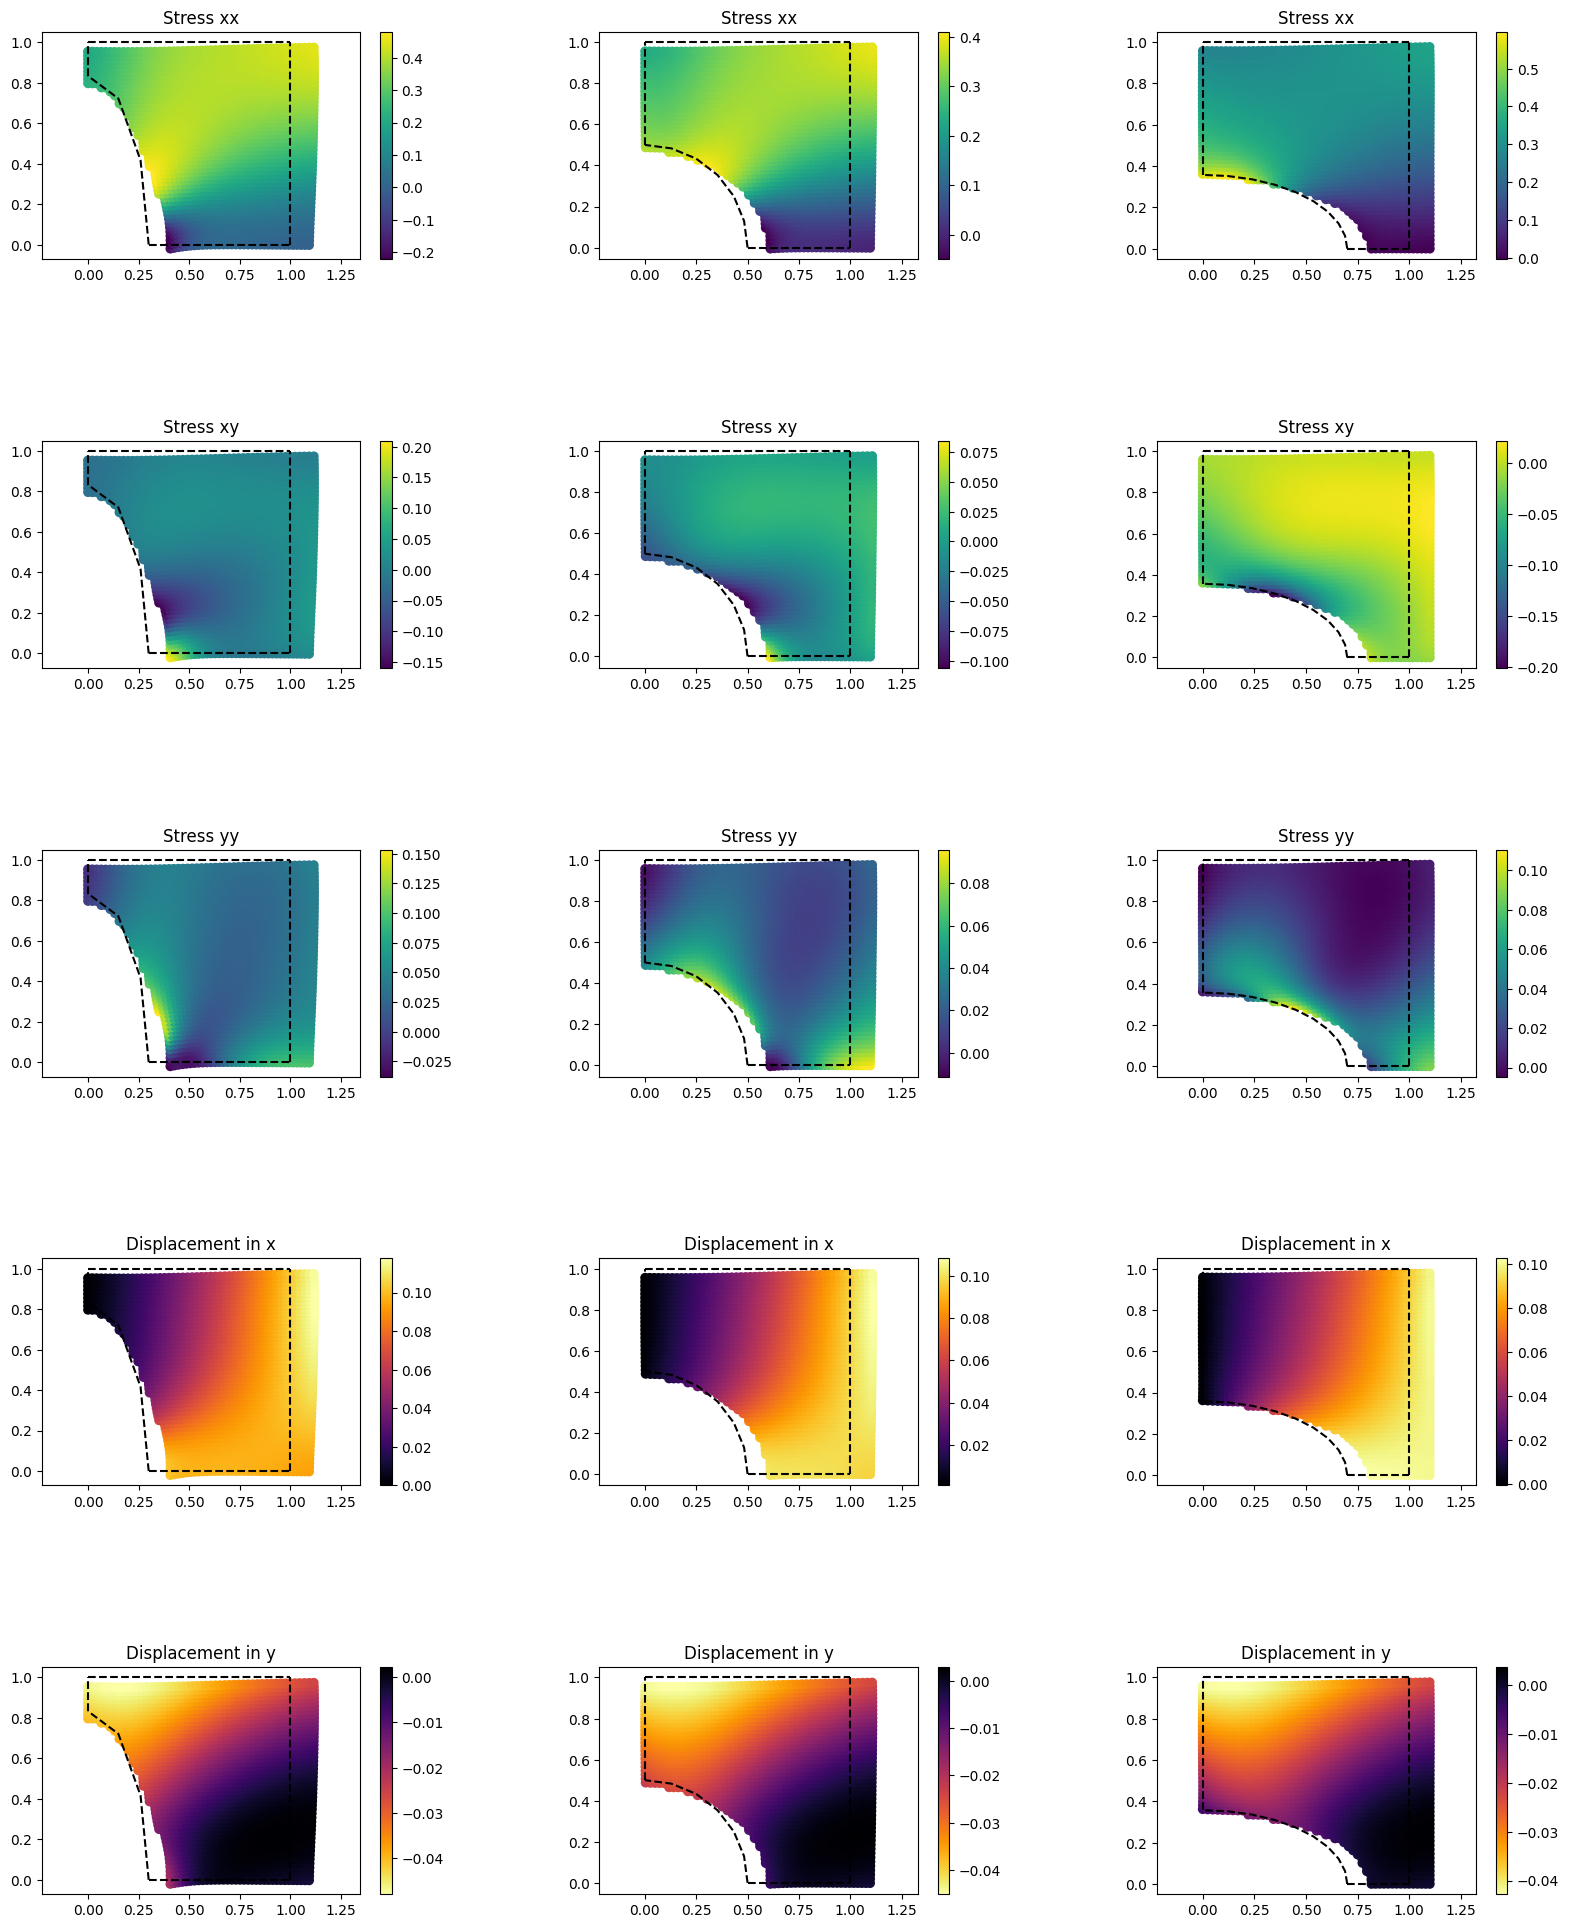

In [ ]:
# Create a validation domain different from the training domain
val_x, val_y = np.meshgrid(np.linspace(0, L, 50), np.linspace(0, L, 50))
val_r = np.linspace(Min_Ra_x, Max_Ra_x, 2500)
val_ry = val_r
for i in range(2500):
    val_ry[i] = (SuAr/(pi*val_r[i])) 
val_domain = np.vstack([val_x.ravel(), val_y.ravel(), val_r, val_ry]).T
#oldcode
#val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_xnew**2)) + ((val_domain[:,1] ** 2)/(Re_ynew**2)) > 1]
#newcode
val_domain = val_domain[((val_domain[:,0] ** 2)/(0.0001**2)) + ((val_domain[:,1] ** 2)/(0.0001**2)) > 1]
val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
val_r = torch.tensor(val_domain[:,1], requires_grad=True).float()


def delete_points_inside_the_hole(val_domain, Re_x, Re_y):
    val_domain = val_domain[((val_domain[:,0] ** 2)/(Re_x**2)) + ((val_domain[:,1] ** 2)/((Re_y)**2)) > 1]
    val_x = torch.tensor(val_domain[:,0], requires_grad=True).float()
    val_y = torch.tensor(val_domain[:,1], requires_grad=True).float()
    return val_x, val_y

def compute_model_prediction(val_x, val_y, radius):
    disp = net(val_x, val_y, radius).detach()
    def_val_x = val_x.detach() + disp[:, 0]
    def_val_y = val_y.detach()+ disp[:, 1]
    strain = epsilon(val_x, val_y, radius, net).detach()
    stress = sigma(strain).detach()
    residual_x, residual_y = pde_residual(val_x, val_y, radius, net)
    return def_val_x, def_val_y, residual_x, residual_y, disp, stress


def create_subplot(def_val_x,def_val_y,variable, title, cmap, boundary_points):
    #top 
    plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), "--k")
    #right
    plt.plot(boundary_points[2], boundary_points[3], "--k")
    #bottom
    plt.plot(boundary_points[6], boundary_points[7], "--k")
    #left
    plt.plot(boundary_points[4], boundary_points[5], "--k")
    #hole
    plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, cmap=cmap)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)

def create_plot():

    radii = [
        (0.3, 0.8333333333333334),
        (0.5, 0.5),
        (0.7, 0.35714285714285715)
    ]

    for j in range(3):
        k = j+1
        new_val_x, new_val_y = delete_points_inside_the_hole(val_domain, radii[j][0], radii[j][1])
        new_def_val_x, new_def_val_y, _, _, disp, stress = compute_model_prediction(new_val_x, new_val_y, torch.tensor(radii[j][0]))

        tuples = [
            (stress[:, 0, 0], "Stress xx", "viridis"),
            (stress[:, 0, 1], "Stress xy", "viridis"),
            (stress[:, 1, 1], "Stress yy", "viridis"), 
            (disp[:, 0], "Displacement in x", "inferno"),
            (disp[:, 1], "Displacement in y", "inferno_r")
        ] 
        for i in range(5):
            plt.subplot(5,3,k)
            k += 3 
            p1 = Plate(*radii[j], L, P)
            data_points = p1.generate_dataset(*radii[j], L, N)
            create_subplot(new_def_val_x,new_def_val_y,*tuples[i],data_points[1])
    plt.subplots_adjust(top = 3.99, right = 2.49, hspace=0.8, wspace=0.4)
    #plt.suptitle("Validation with different radius")
    plt.show


create_plot()


#toDo: Change colour of Subplot Displacement in x and y with cmap="inferno" and cmap="inferno_r"
#create_subplot(disp[:, 0], "Displacement in x",data_test_points[1], cmap="inferno",)
#create_subplot(disp[:, 1], "Displacement in y", data_test_points[1], cmap="inferno_r")


"""""
# Compute model predictions on the validation domain
disp = net(val_x, val_y).detach()
def_val_x = val_x.detach() + disp[:, 0]
def_val_y = val_y.detach()+ disp[:, 1]
strain = epsilon(val_x, val_y, net).detach()
stress = sigma(strain).detach()
residual_x, residual_y = pde_residual(val_x, val_y, net)
"""

"""""
def make_plot(variable, title, boundary_points, **kwargs):
    #top 
    plt.plot(boundary_points[0].detach(), boundary_points[1].detach(), "--k")
    #right
    plt.plot(boundary_points[2], boundary_points[3], "--k")
    #bottom
    plt.plot(boundary_points[6], boundary_points[7], "--k")
    #left
    plt.plot(boundary_points[4], boundary_points[5], "--k")
    #hole
    plt.plot(boundary_points[8].detach(), boundary_points[9].detach(), "--k")
    plt.scatter(def_val_x, def_val_y, c=variable, **kwargs)
    plt.axis("equal")
    plt.colorbar()
    plt.title(title)
    plt.show()
"""""
"""
plt.subplot(5, 3, 1)
create_subplot(stress[:, 0, 0], "Stress xx", data_test_points[1])
plt.subplot(5, 3, 4)
create_subplot(stress[:, 0, 1], "Stress xy", data_test_points[1])
plt.subplot(5, 3, 7)
create_subplot(stress[:, 1, 1], "Stress yy", data_test_points[1])
create_subplot(disp[:, 0], "Displacement in x",data_test_points[1], cmap="inferno",)
create_subplot(disp[:, 1], "Displacement in y", data_test_points[1], cmap="inferno_r")

plt.suptitle("Validation with different radii")
plt.show
"""